# PROJET EVASION

##### Francois Beauvois AKA CyberChinois
##### Nabil Boukraa AKA Devil
##### Sofianne Kasm AKA Ghost 
##### Victor Costa AKA DataNinja

Notebook created by V.Costa 4/4/2019

Last modification : none by none

Nota benne : 

Ce notebook est pour expliquer les raisonements utilisées. 

Le code original est originalement devellopé sur spider.

La version la plus abouti du code sera toujours dans le main.py et pas ici.

Pour la nomenclature, j'ai 2 regles: commencer par un "l" si c'est une variable local et par "a" si c'est un argument qui vient de l'exterieur. J'avoue que je ne la respecte pas toujours...

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

Avant de commencer je crée des routines qui vont etre utiles par la suite.

#### Routine myWriteCSV 
pour ecrire les frames selectionnées au format csv. En realité ce n'est pas un csv (library csv non utilisé) mais je l'enregistre comme ça pour une question de facilité.

In [2]:
def myWriteCSV(aFullFileName,aListeResultats):
#Inputs : aFullFileName - nom du fichier à créer avec le full path
#       : aListeResults - liste avec les numeros à ecrire
    
    with open(aFullFileName, 'w') as output:
        [output.write(str(x+1) + "\n") for x in aListeResultats]
    output.close()

#### Routine myLoadImage 
pour lire les images qui composent la video et retouner une liste.

In [3]:
def myLoadImage(aFullPath,aFileName,aTypeColor='gris',abreak=None):
#Inputs : aFullPath - full path
#       : aFileName - nom du fichier qui contient les images à lire
#       : aTypeColor - type de structure de couleur souhaité (RGB,HSV ou gris)
#       : abreak - limite maximale d'images à extraire
#Output : lDecomposition - liste avec 3 dimensions (dimX, dimY, 3 channels pour la couleur)
#Modif  : Costa 5/4/2019 - correction de l'extraction en gris pour avoir 1 seul channel

    lDecomposition=[]
    lcount=1
    f = open(aFullPath + aFileName, 'rt')
    
    #ecrit comme ça pour minimiser des calculs/evaluations au sein d'une boucle
    if aTypeColor == 'RGB':
        for line in f:
           lDecomposition.append(cv2.imread(aFullPath+line.split()[0]))
           lcount+=1
           if lcount == abreak:
               break
    
    if aTypeColor =='HSV':
        for line in f:
           lDecomposition.append(cv2.imread(aFullPath+line.split()[0],cv2.COLOR_BGR2HSV))
           lcount+=1
           if lcount == abreak:
               break
         
    if aTypeColor =='gris':
        for line in f:
           lIm=cv2.imread(aFullPath+line.split()[0])
           lDecomposition.append(cv2.cvtColor(lIm,cv2.COLOR_BGR2GRAY))
           lcount+=1
           if lcount == abreak:
               break
  
    f.close()
    return lDecomposition


#### Routine myEvaluation 
pour calculer la precision et recall par rapport au gold standart. Je l'ai crée à partir des anotations et je l'ai complété manuellement avec l'intro.

In [4]:
def myEvaluation(aRep,aListeResultats):
#Inputs : aRep - full path
#       : aListeResultats - liste generique avec 1 seule dimension qui contient notre prediction
#Output : precision et recall

    #lecture
    GoldList=[]
    with open(aRep + 'goldResult.csv', encoding="utf-8") as f:
        for line in f:
            GoldList.append(int(line)-1)  # car les images commencent à 1 et python à 0 
    f.close
    
    #initialisation
    true_pos = 0
    false_pos = 0
    false_neg = 0
    
    #evaluation
    for key in aListeResultats:
        if key in GoldList:
            true_pos += 1
        else:
            false_pos += 1
    
    for key in GoldList:
        if key not in aListeResultats:
            false_neg += 1
    
    #calcul indicateurs
    if true_pos + false_pos != 0:
        precision = float(true_pos) / (true_pos + false_pos) * 100.0
    else:
        precision = 0.0
    
    if true_pos + false_neg != 0:
        recall = float(true_pos) / (true_pos + false_neg + false_pos) * 100.0
    else:
        recall = 0.0
        
    return precision, recall

#### Routine myLissage 
pour lisser l'image et ainsi reduire le bruit

In [5]:
def myLissage(aList,aNbImagesLissage=3):
#Inputs : aList - liste generique avec 1 seule dimension qui contient notre prediction
#       : aNbImagesLissage - sur combien d'images on realise la moyenne
#Output : ListLisse - nouvelle liste avec le lissage
    
    #utiliser nombre impair
    ListLisse=[]
    
    #first images
    for i in range(0,int((aNbImagesLissage-1)/2)):
        ListLisse.append(aList[i]) 
    
    for i in range(1,len(aList)-int((aNbImagesLissage-1)/2)):
        valeur=0.0    
        for j in range(int(-(aNbImagesLissage-1)/2),int((aNbImagesLissage-1)/2+1)):
            valeur+=aList[i+j]
        ListLisse.append(valeur/aNbImagesLissage)
    
    #last images
    for i in range(-int((aNbImagesLissage-1)/2),0):
        ListLisse.append(aList[i]) 

    return ListLisse

#### Routine myCutOff
pour selectionner les images à partir d'un seuil (cutoff)

In [6]:
def myCutOff(aCutOff,aList):
#Inputs : aCutoff - entier avec le niveau de seuil
#       : aList - liste generique avec 1 seule dimension qui contient un des traiments
#Output : lResult - liste avec les images qui ont été selectionées
  
    lResult=[]
    for i in range(len(aList)):
        if abs(aList[i]) > aCutOff:
            lResult.append(i)
    return lResult

#### Routine myDivideBlocks
pour decomposer l'image en blocks

In [7]:
def myDivideBlocks(aNbBlocks,aImage):
#Inputs : aNbBlocks - entier avec une dimension du carré (nb blocks=x^2)
#       : aImage - image à decouper avec 1 seul channel
#Output : liste_block_frame - liste avec les X blocks
  
    (dimYpix, dimXpix) = aImage.shape

    dimYpixBlock=int(dimYpix/aNbBlocks)
    dimXpixBlock=int(dimXpix/aNbBlocks)    
    
    liste_block_frame=[]
    for bl in range(0,nbBlocks**2) : liste_block_frame.append(aImage
                   [(bl//nbBlocks)*dimYpixBlock : (bl//nbBlocks+1)*dimYpixBlock,
                    (bl%nbBlocks)*dimXpixBlock :(bl%nbBlocks+1)*dimXpixBlock])

    return liste_block_frame

# Modelisation

In [8]:
#Gestion des paths pour garantir que ça ne pete pas.
#Si vous saviez faire ça correctement, merci de partager l'info

#path = r"C:\Users\vicks\Documents\Ecole\Multimedia\data\\"
#RepCode=r"C:\Users\vicks\Documents\Ecole\Multimedia\evasion\\"

path = r"C:\Users\costav\Documents\big data\Ecole\Multimedia\data\\"
RepCode=r"C:\Users\costav\Documents\big data\Ecole\Multimedia\evasion\\"

os.chdir(path)
RepImages=(path)

## Le gris

In [9]:
#load
dbgris = myLoadImage(RepImages,'listfull.txt','gris')
NbImages=len(dbgris)

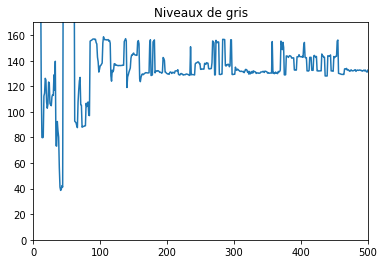

In [10]:
#traitement 1 : la moyenne
niv_gris_avg =[np.mean(x) for x in dbgris]
mGris=niv_gris_avg

#lissage de la moyenne (utiliser nombre impair) -> pas une bonne iddée
#niv_gris_avg_liss=myLissage(niv_gris_avg,3)
#mGris=niv_gris_avg_liss

#visu
plt.axis([0, 500, 0, 170])
plt.title('Niveaux de gris')
plt.plot(niv_gris_avg)
#plt.plot(niv_gris_avg_liss)
plt.show()

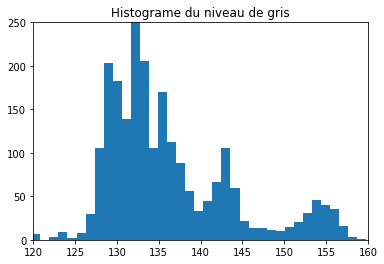

In [11]:
#histogramme
plt.hist(niv_gris_avg,200)  # 200 tranches
#plt.hist(niv_gris_avg_liss,200)
plt.title('Histograme du niveau de gris')
plt.axis([120, 160, 0, 250])
plt.show()

In [12]:
#calcul de la derivé (en pratique, c'est juste la difference)
derive_niv_gris_avg=[]
derive_niv_gris_avg.append(0) #fist element
for i in range(1,NbImages-1):
    derive_niv_gris_avg.append(niv_gris_avg[i]-niv_gris_avg[i-1])
derive_niv_gris_avg.append(0) #last element

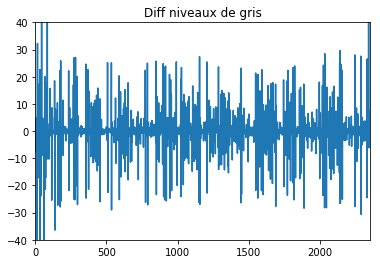

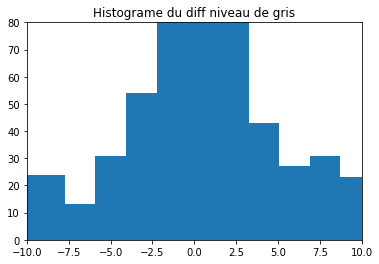

In [13]:
#graphs
plt.axis([0, NbImages, -40, 40])
plt.title('Diff niveaux de gris')
plt.plot(derive_niv_gris_avg)
plt.show()

#histogramme
plt.hist(derive_niv_gris_avg,200)
plt.title('Histograme du diff niveau de gris')
plt.axis([-10, 10, 0, 80])
plt.show()

Ce dernier histogramme montre que un seuil entre 20 et 30 doit le faire (lire sur l'axe des Y). On veut seuiller où les diffs sont grands.

Alons tester 20.

In [14]:
myResult=myCutOff(20,derive_niv_gris_avg)
precision, recall = myEvaluation(RepCode,myResult)
print(precision)
print(recall)

96.22641509433963
19.729206963249517


Faisons ça en automatique.

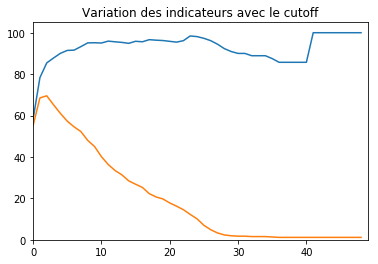

Best seuil : 2
Precision of best recall:  85.41226215644821
Best Recall: 69.53528399311531


In [15]:
liste_precision=[]
liste_recall=[]
liste_myResult=[]
liste_NbDetections=[]

for i in range(1,50): #teste entre 1 et 50 en seuille
    liste_myResult=myCutOff(i,derive_niv_gris_avg)
    
    lprecision, lrecall = myEvaluation(RepCode,liste_myResult)
    liste_precision.append(lprecision)
    liste_recall.append(lrecall)
    liste_NbDetections.append(len(liste_myResult))
    
#visu
plt.axis([0, len(liste_recall), 0, max(liste_precision)+5])
plt.title('Variation des indicateurs avec le cutoff')
plt.plot(liste_precision)
plt.plot(liste_recall)
plt.show()

#max
CutoffOptimal=liste_recall.index(max(liste_recall))
print('Best seuil :',CutoffOptimal)
print('Precision of best recall: ' , liste_precision[CutoffOptimal])
print('Best Recall:',max(liste_recall))

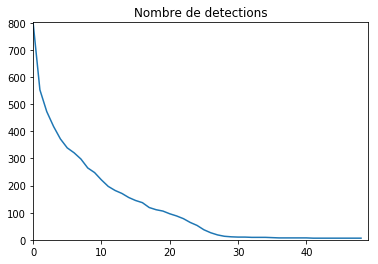

In [16]:
#visu
plt.axis([0, len(liste_precision), 0, max(liste_NbDetections)])
plt.title('Nombre de detections')
plt.plot(liste_NbDetections)
plt.show()

Alons simuler et enregistrer pour le voir avec l'outil excel myTreatment.xlsm :

In [17]:
myResult=myCutOff(3,derive_niv_gris_avg)
precision, recall = myEvaluation(RepCode,myResult)
print (precision, recall)

85.41226215644821 69.53528399311531


In [18]:
myWriteCSV(RepCode+'myResult.csv',myResult)  #ne pas changer le nom

## Le Rouge

In [19]:
#load
dbRGB = myLoadImage(RepImages,'listfull.txt','RGB')
dbRed=[]
dbBlue=[]
dbGreen=[]

for i in range(0,len(dbRGB)):
    (lBlue, lGreen, lRed) = cv2.split(dbRGB[i])
    dbBlue.append(lBlue)    
    dbGreen.append(lGreen)
    dbRed.append(lRed)

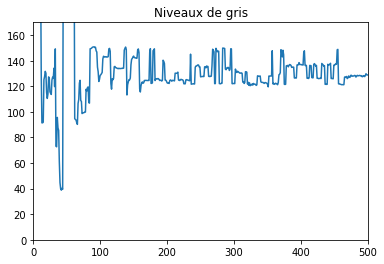

In [20]:
#traitement 1 : la moyenne
niv_channel_avg =[np.mean(x) for x in dbRed]

#lissage de la moyenne (utiliser nombre impair)
#niv_channel_avg_liss=myLissage(niv_channel_avg,3)

mR=niv_channel_avg

#visu
plt.axis([0, 500, 0, 170])
plt.title('Niveaux de gris')
plt.plot(niv_channel_avg)
#plt.plot(niv_channel_avg_liss)
plt.show()

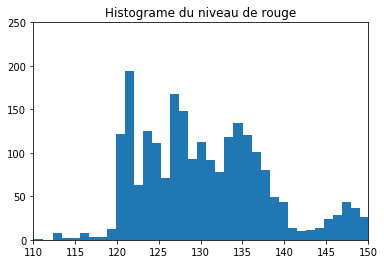

In [21]:
#histogramme
plt.hist(niv_channel_avg,200)  # 200 tranches
#plt.hist(niv_channel_avg_liss,200)
plt.title('Histograme du niveau de rouge')
plt.axis([110, 150, 0, 250])
plt.show()

In [22]:
#calcul de la derivé (en pratique, c'est juste la difference)
derive_channel=[]
derive_channel.append(0) #fist element
for i in range(1,len(niv_channel_avg)-1):
    derive_channel.append(niv_channel_avg[i]-niv_channel_avg[i-1])
derive_channel.append(0) #last element

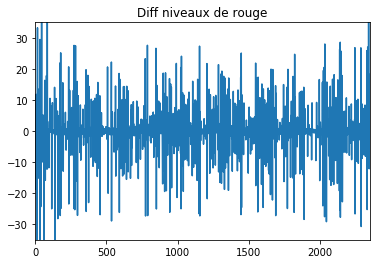

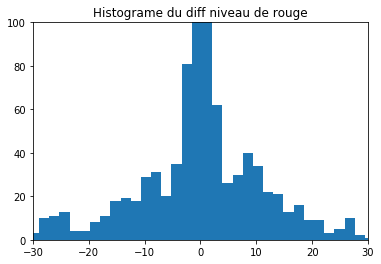

In [23]:
#graphs
plt.axis([0, NbImages, -35, 35])
plt.title('Diff niveaux de rouge')
plt.plot(derive_channel)
plt.show()

#histogramme
plt.hist(derive_channel,200)
plt.title('Histograme du diff niveau de rouge')
plt.axis([-30, 30, 0, 100])
plt.show()

Ce dernier histogramme montre que un seuil entre 20 et 30 doit le faire (lire sur l'axe des Y). On veut seuiller où les diffs sont grands.

Alons tester 30.

In [24]:
myResult=myCutOff(30,derive_channel)
precision, recall = myEvaluation(RepCode,myResult)
print(precision)
print(recall)

90.9090909090909
1.9455252918287937


Faisons ça en automatique.

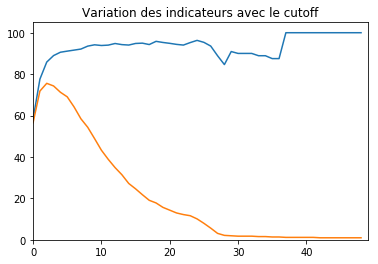

Best seuil : 2
Precision of best recall:  85.8252427184466
Best Recall: 75.55555555555556


In [25]:
liste_precision=[]
liste_recall=[]
liste_myResult=[]

for i in range(1,50): #teste entre 1 et 50 en seuille
    liste_myResult=myCutOff(i,derive_channel)
    
    lprecision, lrecall = myEvaluation(RepCode,liste_myResult)
    liste_precision.append(lprecision)
    liste_recall.append(lrecall)
    
#visu
plt.axis([0, len(liste_recall), 0, max(liste_precision)+5])
plt.title('Variation des indicateurs avec le cutoff')
plt.plot(liste_precision)
plt.plot(liste_recall)
plt.show()

#max
CutoffOptimal=liste_recall.index(max(liste_recall))
print('Best seuil :',CutoffOptimal)
print('Precision of best recall: ' , liste_precision[CutoffOptimal])
print('Best Recall:',max(liste_recall))

Attention : il faut prendre x+1 car le graphique commence à 0.


Alons simuler et enregistrer ce cas pour le voir avec l'outil excel myTreatment.xlsm :

In [26]:
myResult=myCutOff(3,derive_channel) #x+1
precision, recall = myEvaluation(RepCode,myResult)
print (precision, recall)

85.8252427184466 75.55555555555556


In [27]:
myWriteCSV(RepCode+'myResult.csv',myResult)  #ne pas changer le nom

## Le Vert

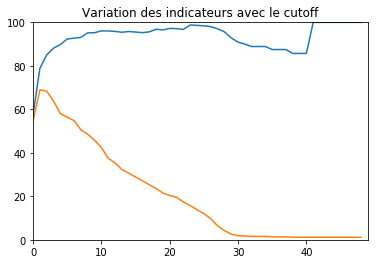

Best seuil : 1
Precision of best recall:  78.87067395264117
Best Recall: 68.94904458598727


In [28]:
#traitement 1 : la moyenne
niv_channel_avg =[np.mean(x) for x in dbGreen]

#lissage de la moyenne (utiliser nombre impair)
#niv_channel_avg_liss=myLissage(niv_channel_avg,3)
mG=niv_channel_avg

#calcul de la derivé (en pratique, c'est juste la difference)
derive_channel=[]
derive_channel.append(0) #fist element
for i in range(1,len(niv_channel_avg)-1):
    derive_channel.append(niv_channel_avg[i]-niv_channel_avg[i-1])
derive_channel.append(0) #last element

#evaluation automatique
liste_precision=[]
liste_recall=[]
liste_myResult=[]

for i in range(1,50): #teste entre 1 et 50 en seuil
    liste_myResult=myCutOff(i,derive_channel)
    lprecision, lrecall = myEvaluation(RepCode,liste_myResult)
    liste_precision.append(lprecision)
    liste_recall.append(lrecall)
    
#visu
plt.axis([0, len(liste_precision), 0, 
          max(max(liste_precision),max(liste_recall))])
plt.title('Variation des indicateurs avec le cutoff')
plt.plot(liste_precision)
plt.plot(liste_recall)
plt.show()

#max
CutoffOptimal=liste_recall.index(max(liste_recall))
print('Best seuil :',CutoffOptimal)
print('Precision of best recall: ' , liste_precision[CutoffOptimal])
print('Best Recall:',max(liste_recall))

In [29]:
myResult=myCutOff(2,derive_channel) #x+1
precision, recall = myEvaluation(RepCode,myResult)
print (precision, recall)

myWriteCSV(RepCode+'myResult.csv',myResult)  #ne pas changer le nom

78.87067395264117 68.94904458598727


## Le Blue

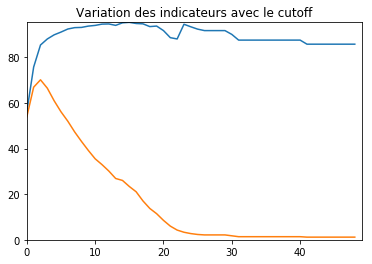

Best seuil : 2
Precision of best recall:  85.35564853556485
Best Recall: 70.10309278350515


In [30]:
#traitement 1 : la moyenne
niv_channel_avg =[np.mean(x) for x in dbBlue]

#lissage de la moyenne (utiliser nombre impair)
#niv_channel_avg_liss=myLissage(niv_channel_avg,3)
mB=niv_channel_avg

#calcul de la derivé (en pratique, c'est juste la difference)
derive_channel=[]
derive_channel.append(0) #fist element
for i in range(1,len(niv_channel_avg)-1):
    derive_channel.append(niv_channel_avg[i]-niv_channel_avg[i-1])
derive_channel.append(0) #last element

#evaluation automatique
liste_precision=[]
liste_recall=[]
liste_myResult=[]

for i in range(1,50): #teste entre 1 et 50 en seuil
    liste_myResult=myCutOff(i,derive_channel)
    
    lprecision, lrecall = myEvaluation(RepCode,liste_myResult)
    liste_precision.append(lprecision)
    liste_recall.append(lrecall)
    
#visu
plt.axis([0, len(liste_precision), 0, 
          max(max(liste_precision),max(liste_recall))])
plt.title('Variation des indicateurs avec le cutoff')
plt.plot(liste_precision)
plt.plot(liste_recall)
plt.show()

#max
CutoffOptimal=liste_recall.index(max(liste_recall))
print('Best seuil :',CutoffOptimal)
print('Precision of best recall: ' , liste_precision[CutoffOptimal])
print('Best Recall:',max(liste_recall))

In [31]:
myResult=myCutOff(3,derive_channel) #x+1
precision, recall = myEvaluation(RepCode,myResult)
print (precision, recall)

myWriteCSV(RepCode+'myResult.csv',myResult)  #ne pas changer le nom

85.35564853556485 70.10309278350515


## Le Hue (en HSV)

In [32]:
#load
dbHSV = myLoadImage(RepImages,'listfull.txt','HSV')
dbH=[]
dbS=[]
dbV=[]

for i in range(0,len(dbHSV)):
    (lH, lS, lV) = cv2.split(dbHSV[i])
    dbH.append(lH)    
    dbS.append(lS)
    dbV.append(lV)

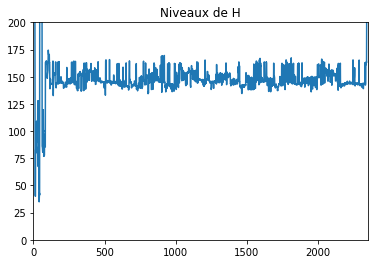

In [33]:
#traitement 1 : la moyenne
niv_channel_avg =[np.mean(x) for x in dbH]

#lissage de la moyenne (utiliser nombre impair)
#niv_channel_avg_liss=myLissage(niv_channel_avg,3)
mH=niv_channel_avg

#visu
plt.axis([0, NbImages, 0, 200])
plt.title('Niveaux de H')
plt.plot(niv_channel_avg)
#plt.plot(niv_channel_avg_liss)
plt.show()

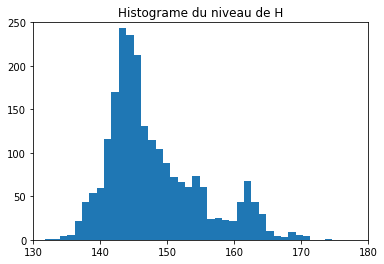

In [34]:
#histogramme à 200 tranches
plt.hist(niv_channel_avg,200)  
plt.title('Histograme du niveau de H')
plt.axis([130, 180, 0, 250])
plt.show()

In [35]:
#calcul de la derivé (en pratique, c'est juste la difference)
derive_channel=[]
derive_channel.append(0) #fist element
for i in range(1,len(niv_channel_avg)-1):
    derive_channel.append(niv_channel_avg[i]-niv_channel_avg[i-1])
derive_channel.append(0) #last element

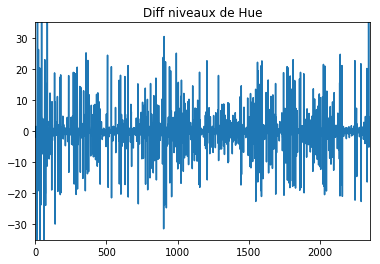

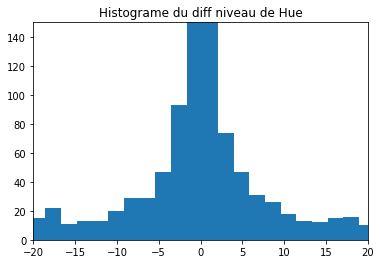

In [36]:
#graphs
plt.axis([0, NbImages, -35, 35])
plt.title('Diff niveaux de Hue')
plt.plot(derive_channel)
plt.show()

#histogramme
plt.hist(derive_channel,200)
plt.title('Histograme du diff niveau de Hue')
plt.axis([-20, 20, 0, 150])
plt.show()

Ce dernier histogramme montre que un seuil entre 20 et 30 doit le faire (lire sur l'axe des Y). On veut seuiller où les diffs sont grands.

Alons tester 30.

In [37]:
myResult=myCutOff(30,derive_channel)
precision, recall = myEvaluation(RepCode,myResult)
print(precision)
print(recall)

90.9090909090909
1.9455252918287937


Faisons ça en automatique.

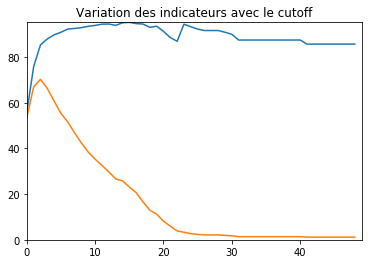

Best seuil : 2
Precision of best recall:  85.38622129436325
Best Recall: 70.27491408934708


In [38]:
liste_precision=[]
liste_recall=[]
liste_myResult=[]

for i in range(1,50): #teste entre 1 et 50 en seuil
    liste_myResult=myCutOff(i,derive_channel)
    
    lprecision, lrecall = myEvaluation(RepCode,liste_myResult)
    liste_precision.append(lprecision)
    liste_recall.append(lrecall)
    
#visu
plt.axis([0, len(liste_precision), 0, 
          max(max(liste_precision),max(liste_recall))])
plt.title('Variation des indicateurs avec le cutoff')
plt.plot(liste_precision)
plt.plot(liste_recall)
plt.show()

#max
CutoffOptimal=liste_recall.index(max(liste_recall))
print('Best seuil :',CutoffOptimal)
print('Precision of best recall: ' , liste_precision[CutoffOptimal])
print('Best Recall:',max(liste_recall))

Attention : il faut prendre x+1 car le graphique commence à 0.


Alons simuler et enregistrer ce cas pour le voir avec l'outil excel myTreatment.xlsm :

In [39]:
myResult=myCutOff(3,derive_channel) #x+1
precision, recall = myEvaluation(RepCode,myResult)
print (precision, recall)

85.38622129436325 70.27491408934708


In [40]:
myWriteCSV(RepCode+'myResult.csv',myResult)  #ne pas changer le nom

## Le S de HSV

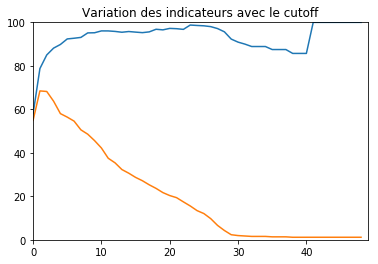

Best seuil : 1
Precision of best recall:  78.75457875457876
Best Recall: 68.47133757961782


In [41]:
#traitement 1 : la moyenne
niv_channel_avg =[np.mean(x) for x in dbS]

#lissage de la moyenne (utiliser nombre impair)
#niv_channel_avg_liss=myLissage(niv_channel_avg,3)
mS=niv_channel_avg

#calcul de la derivé (en pratique, c'est juste la difference)
derive_channel=[]
derive_channel.append(0) #fist element
for i in range(1,len(niv_channel_avg)-1):
    derive_channel.append(niv_channel_avg[i]-niv_channel_avg[i-1])
derive_channel.append(0) #last element

#evaluation automatique
liste_precision=[]
liste_recall=[]
liste_myResult=[]

for i in range(1,50): #teste entre 1 et 50 en seuil
    liste_myResult=myCutOff(i,derive_channel)
    
    lprecision, lrecall = myEvaluation(RepCode,liste_myResult)
    liste_precision.append(lprecision)
    liste_recall.append(lrecall)
    
#visu
plt.axis([0, len(liste_precision), 0, 
          max(max(liste_precision),max(liste_recall))])
plt.title('Variation des indicateurs avec le cutoff')
plt.plot(liste_precision)
plt.plot(liste_recall)
plt.show()

#max
CutoffOptimal=liste_recall.index(max(liste_recall))
print('Best seuil :',CutoffOptimal)
print('Precision of best recall: ' , liste_precision[CutoffOptimal])
print('Best Recall:',max(liste_recall))

In [42]:
myResult=myCutOff(2,derive_channel) #x+1
precision, recall = myEvaluation(RepCode,myResult)
print (precision, recall)

myWriteCSV(RepCode+'myResult.csv',myResult)  #ne pas changer le nom

78.75457875457876 68.47133757961782


## Le V de HSV

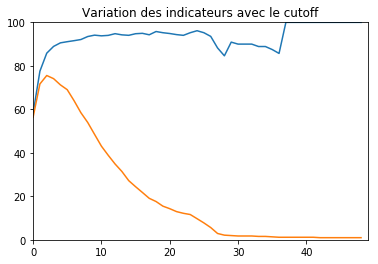

Best seuil : 2
Precision of best recall:  85.8252427184466
Best Recall: 75.55555555555556


In [43]:
#traitement 1 : la moyenne
niv_channel_avg =[np.mean(x) for x in dbV]

#lissage de la moyenne (utiliser nombre impair)
#niv_channel_avg=myLissage(niv_channel_avg,3)
mV=niv_channel_avg

#calcul de la derivé (en pratique, c'est juste la difference)
derive_channel=[]
derive_channel.append(0) #fist element
for i in range(1,len(niv_channel_avg)-1):
    derive_channel.append(niv_channel_avg[i]-niv_channel_avg[i-1])
derive_channel.append(0) #last element

#evaluation automatique
liste_precision=[]
liste_recall=[]
liste_myResult=[]

for i in range(1,50): #teste entre 1 et 50 en seuil
    liste_myResult=myCutOff(i,derive_channel)
    
    lprecision, lrecall = myEvaluation(RepCode,liste_myResult)
    liste_precision.append(lprecision)
    liste_recall.append(lrecall)
    
#visu
plt.axis([0, len(liste_precision), 0, 
          max(max(liste_precision),max(liste_recall))])
plt.title('Variation des indicateurs avec le cutoff')
plt.plot(liste_precision)
plt.plot(liste_recall)
plt.show()

#max
CutoffOptimal=liste_recall.index(max(liste_recall))
print('Best seuil :',CutoffOptimal)
print('Precision of best recall: ' , liste_precision[CutoffOptimal])
print('Best Recall:',max(liste_recall))

In [44]:
myResult=myCutOff(3,derive_channel) #x+1
precision, recall = myEvaluation(RepCode,myResult)
print (precision, recall)

myWriteCSV(RepCode+'myResult.csv',myResult)  #ne pas changer le nom

85.8252427184466 75.55555555555556


### Combinaison des 7 channels (RGBHSVgris)

In [45]:
#Calcul de la distance euclidienne
combi=[mR,mG,mB,mH,mS,mV,mGris]

liste_distance=[]
liste_distance.append(0) #initialisation
for i in range(1,NbImages):
    ldistance=0.0
    for channel in combi:
        ldistance+=(channel[i]-channel[i-1])**2
    liste_distance.append(math.sqrt(ldistance))

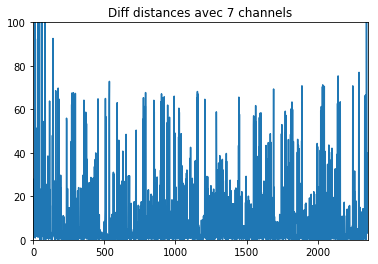

In [46]:
#graphs
plt.axis([0, NbImages, 0, 100])
plt.title('Diff distances avec 7 channels')
plt.plot(liste_distance)
plt.show()

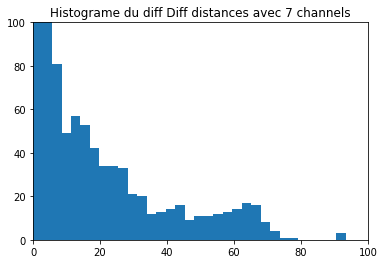

In [47]:
#histogramme
plt.hist(liste_distance,200)
plt.title('Histograme du diff Diff distances avec 7 channels')
plt.axis([0, 100, 0, 100])
plt.show()

In [48]:
liste_myResult=myCutOff(3,liste_distance)
(lprecision, lrecall) = myEvaluation(RepCode,liste_myResult)
print(len(liste_myResult))

808


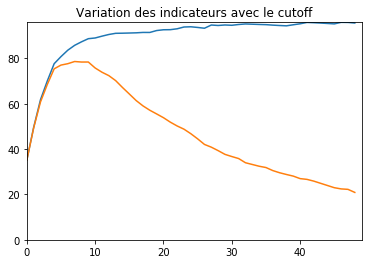

Best seuil : 7
Precision of best recall:  85.74074074074073
Best Recall: 78.60780984719864


In [49]:
#evaluation automatique
liste_precision=[]
liste_recall=[]
liste_myResult=[]

for i in range(1,50): #teste entre 1 et 50 en seuil
    liste_myResult=myCutOff(i,liste_distance)
    lprecision, lrecall = myEvaluation(RepCode,liste_myResult)
    liste_precision.append(lprecision)
    liste_recall.append(lrecall)
    
#visu
plt.axis([0, len(liste_precision), 0, 
          max(max(liste_precision),max(liste_recall))])
plt.title('Variation des indicateurs avec le cutoff')
plt.plot(liste_precision)
plt.plot(liste_recall)
plt.show()

#max
CutoffOptimal=liste_recall.index(max(liste_recall))
print('Best seuil :',CutoffOptimal)
print('Precision of best recall: ' , liste_precision[CutoffOptimal])
print('Best Recall:',max(liste_recall))

In [50]:
myResult=myCutOff(8,liste_distance) #x+1
precision, recall = myEvaluation(RepCode,myResult)
print (precision, recall)

myWriteCSV(RepCode+'myResult.csv',myResult)  #ne pas changer le nom

85.74074074074073 78.60780984719864


## Separation en blocks

In [51]:
nbBlocks=4 #pour 4x4
liste_im=myLoadImage(RepImages,'listfull.txt','gris')

liste_block_images=[]
for im in range(0,len(liste_im)):
    liste_block_images.append(myDivideBlocks(nbBlocks,liste_im[im]))

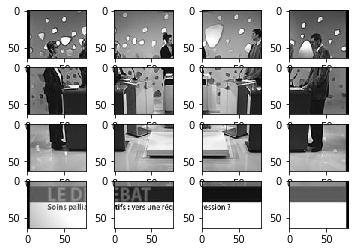

In [52]:
#Verification par example avec l'image 200
plt.figure()
for i in range(0,nbBlocks**2):    
    plt.subplot(4,4,i+1)
    plt.imshow(liste_block_images[200][i],cmap='gray')

In [53]:
#calcul de la moyenne de chaque block suivi de lisage

#le lissage n'est peut etre pas une bonne idée vu le faible grand pas de temps de l'extraction

megaliste=[]
for iblock in range(0,nbBlocks**2):
    liste=[]
    #liste_moyenne_block_lisse_par_image=[]
    for im in range(0,NbImages): 
        liste.append(np.mean(liste_block_images[im][iblock][:,:,]))
        #liste_moyenne_block_lisse_par_image=myLissage(liste,3)
    #megaliste.append(liste_moyenne_block_lisse_par_image)
    megaliste.append(liste)
    
megalisteGris=megaliste

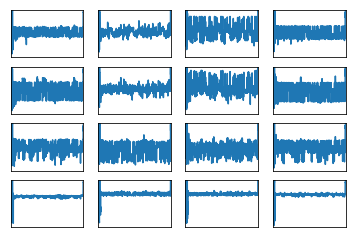

In [54]:
#visu
plt.figure()
for i in range(0,nbBlocks**2):    
    plt.subplot(4,4,i+1)
    plt.xticks([]), plt.yticks([])
    plt.axis([0, NbImages, 0, 250])
    plt.plot(megaliste[i])

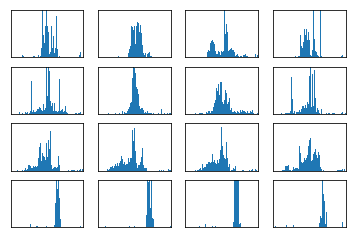

In [55]:
#histogrammes
plt.figure()
for i in range(0,nbBlocks**2):
    plt.subplot(4,4,i+1)
    plt.hist(megaliste[i],200)  # 200 tranches
    plt.xticks([]), plt.yticks([])
    plt.axis([0, 250, 0, 100])

In [56]:
#calcul de la derivé (en pratique, c'est juste la difference)
derive_par_block=[]
for iblock in range(0,nbBlocks**2):
    derive=[]
    derive.append(0)
    for im in range(1,NbImages): 
        derive.append(megaliste[iblock][im]-megaliste[iblock][im-1])
    derive_par_block.append(derive)

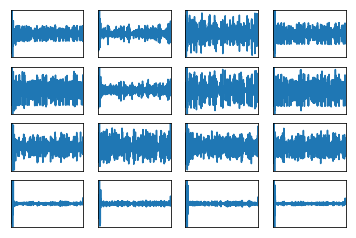

In [57]:
#graphs
plt.figure()
for i in range(0,nbBlocks**2):
    plt.subplot(4,4,i+1)
    plt.xticks([]), plt.yticks([])   
    plt.axis([0, NbImages, -150, 150])
    plt.plot(derive_par_block[i])

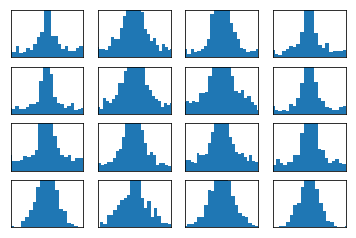

In [58]:
#histogramme
plt.figure()
for i in range(0,nbBlocks**2):
    plt.subplot(4,4,i+1)
    plt.xticks([]), plt.yticks([])   
    plt.hist(derive_par_block[i],200)
    plt.axis([-20, 20, 0, 80])

In [59]:
seuil1=6
seuil2=0.45
myResult=[]

for im in range(0,len(liste_im)): 
    blockcounteur=0
    for iblock in range(0,nbBlocks**2):
        if abs(derive_par_block[iblock][im])>seuil1:
            blockcounteur+=+1
    if float(blockcounteur)/float(nbBlocks**2)>=seuil2:
        myResult.append(im)
        
precision, recall = myEvaluation(RepCode,myResult)
print(precision)
print(recall)
myWriteCSV(RepCode+'myResult.csv',myResult)  #ne pas changer le nom

87.263339070568
86.51877133105802


In [60]:
liste_liste_precision=[]
liste_liste_recall=[]

for seuil1 in range(0,10):
    liste_precision=[]
    liste_recall=[]
    
    for seuil2 in range(0,100,10):
        liste_myResult=[]
        
        for im in range(0,NbImages): 
            blockcounteur=0
            for iblock in range(0,nbBlocks**2):
                if abs(derive_par_block[iblock][im])>seuil1:
                    blockcounteur=blockcounteur+1
           
            if float(blockcounteur)/float(nbBlocks**2)>=float(seuil2)/float(100):
                liste_myResult.append(im)
        
        lprecision, lrecall = myEvaluation(RepCode,liste_myResult)
        liste_precision.append(lprecision)
        liste_recall.append(lrecall)
    
    liste_liste_precision.append(liste_precision)
    liste_liste_recall.append(liste_recall)

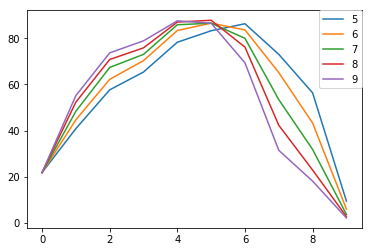

In [61]:
#visu
#  y est le recall
#  x est le seuil2 sur le nombre le % blockes (ex: 5 => 50% => 8 sur 16)
# chaque courbe correspond au seuil1 (niveau de modification sur 1 block)
for i in range(5,10):
    plt.plot(liste_liste_recall[i],label=(i))
    plt.legend(ncol=1, borderaxespad=0.)

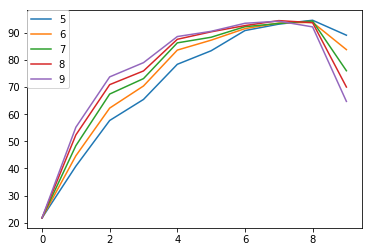

In [62]:
#visu
for i in range(5,10):
    plt.plot(liste_liste_precision[i],label=i)
    plt.legend(ncol=1, borderaxespad=0.)

## Le Rouge

In [63]:
#load
dbRGB = myLoadImage(RepImages,'listfull.txt','RGB')
dbRed=[]
dbBlue=[]
dbGreen=[]

for i in range(0,NbImages):
    (lBlue, lGreen, lRed) = cv2.split(dbRGB[i])
    dbBlue.append(lBlue)    
    dbGreen.append(lGreen)
    dbRed.append(lRed)

nbBlocks=4 #pour 4x4
liste_im=dbRed

liste_block_images=[]
for im in range(0,NbImages):
    liste_block_images.append(myDivideBlocks(nbBlocks,liste_im[im]))

#calcul de la moyenne de chaque block
megaliste=[]
for iblock in range(0,nbBlocks**2):
    liste=[]
    for im in range(0,NbImages): 
        liste.append(np.mean(liste_block_images[im][iblock][:,:,]))
    megaliste.append(liste)
    
megalisteR=megaliste

#calcul de la derivé (en pratique, c'est juste la difference)
derive_par_block=[]
for iblock in range(0,nbBlocks**2):
    derive=[]
    derive.append(0)
    for im in range(1,NbImages): 
        derive.append(megaliste[iblock][im]-megaliste[iblock][im-1])
    derive_par_block.append(derive)

In [64]:
seuil1=7
seuil2=0.5
myResult=[]

for im in range(0,len(liste_im)): 
    blockcounteur=0
    for iblock in range(0,nbBlocks**2):
        if abs(derive_par_block[iblock][im])>seuil1:
            blockcounteur+=+1
    if float(blockcounteur)/float(nbBlocks**2)>=seuil2:
        myResult.append(im)
        
precision, recall = myEvaluation(RepCode,myResult)
print(precision)
print(recall)
myWriteCSV(RepCode+'myResult.csv',myResult)  #ne pas changer le nom

89.92805755395683
88.02816901408451


## Le Bleu

In [65]:
nbBlocks=4 #pour 4x4
liste_im=dbBlue

liste_block_images=[]
for im in range(0,NbImages):
    liste_block_images.append(myDivideBlocks(nbBlocks,liste_im[im]))

#calcul de la moyenne de chaque block
megaliste=[]
for iblock in range(0,nbBlocks**2):
    liste=[]
    for im in range(0,NbImages): 
        liste.append(np.mean(liste_block_images[im][iblock][:,:,]))
    megaliste.append(liste)
    
megalisteB=megaliste

#calcul de la derivé (en pratique, c'est juste la difference)
derive_par_block=[]
for iblock in range(0,nbBlocks**2):
    derive=[]
    derive.append(0)
    for im in range(1,NbImages): 
        derive.append(megaliste[iblock][im]-megaliste[iblock][im-1])
    derive_par_block.append(derive)

In [66]:
seuil1=10
seuil2=0.50
myResult=[]

for im in range(0,len(liste_im)): 
    blockcounteur=0
    for iblock in range(0,nbBlocks**2):
        if abs(derive_par_block[iblock][im])>seuil1:
            blockcounteur+=+1
    if float(blockcounteur)/float(nbBlocks**2)>=seuil2:
        myResult.append(im)
        
precision, recall = myEvaluation(RepCode,myResult)
print(precision)
print(recall)
myWriteCSV(RepCode+'myResult.csv',myResult)  #ne pas changer le nom

89.89169675090253
87.67605633802818


## Le Vert

In [67]:
nbBlocks=4 #pour 4x4
liste_im=dbGreen

liste_block_images=[]
for im in range(0,NbImages):
    liste_block_images.append(myDivideBlocks(nbBlocks,liste_im[im]))

#calcul de la moyenne de chaque block
megaliste=[]
for iblock in range(0,nbBlocks**2):
    liste=[]
    for im in range(0,NbImages): 
        liste.append(np.mean(liste_block_images[im][iblock][:,:,]))
    megaliste.append(liste)
    
megalisteG=megaliste

#calcul de la derivé (en pratique, c'est juste la difference)
derive_par_block=[]
for iblock in range(0,nbBlocks**2):
    derive=[]
    derive.append(0)
    for im in range(1,NbImages): 
        derive.append(megaliste[iblock][im]-megaliste[iblock][im-1])
    derive_par_block.append(derive)

In [68]:
seuil1=8
seuil2=0.5
myResult=[]

for im in range(0,len(liste_im)): 
    blockcounteur=0
    for iblock in range(0,nbBlocks**2):
        if abs(derive_par_block[iblock][im])>seuil1:
            blockcounteur+=+1
    if float(blockcounteur)/float(nbBlocks**2)>=seuil2:
        myResult.append(im)
        
precision, recall = myEvaluation(RepCode,myResult)
print(precision)
print(recall)
myWriteCSV(RepCode+'myResult.csv',myResult)  #ne pas changer le nom

90.1639344262295
87.45583038869258


## Le Hue

In [69]:
nbBlocks=4 #pour 4x4
liste_im=dbH

liste_block_images=[]
for im in range(0,NbImages):
    liste_block_images.append(myDivideBlocks(nbBlocks,liste_im[im]))

#calcul de la moyenne de chaque block
megaliste=[]
for iblock in range(0,nbBlocks**2):
    liste=[]
    for im in range(0,NbImages): 
        liste.append(np.mean(liste_block_images[im][iblock][:,:,]))
    megaliste.append(liste)
    
megalisteH=megaliste

#calcul de la derivé (en pratique, c'est juste la difference)
derive_par_block=[]
for iblock in range(0,nbBlocks**2):
    derive=[]
    derive.append(0)
    for im in range(1,NbImages): 
        derive.append(megaliste[iblock][im]-megaliste[iblock][im-1])
    derive_par_block.append(derive)

In [70]:
seuil1=10
seuil2=0.50
myResult=[]

for im in range(0,len(liste_im)): 
    blockcounteur=0
    for iblock in range(0,nbBlocks**2):
        if abs(derive_par_block[iblock][im])>seuil1:
            blockcounteur+=+1
    if float(blockcounteur)/float(nbBlocks**2)>=seuil2:
        myResult.append(im)
        
precision, recall = myEvaluation(RepCode,myResult)
print(precision)
print(recall)
myWriteCSV(RepCode+'myResult.csv',myResult)  #ne pas changer le nom

90.09009009009009
88.18342151675485


## La Saturation

In [71]:
nbBlocks=4 #pour 4x4
liste_im=dbS

liste_block_images=[]
for im in range(0,NbImages):
    liste_block_images.append(myDivideBlocks(nbBlocks,liste_im[im]))

#calcul de la moyenne de chaque block
megaliste=[]
for iblock in range(0,nbBlocks**2):
    liste=[]
    for im in range(0,NbImages): 
        liste.append(np.mean(liste_block_images[im][iblock][:,:,]))
    megaliste.append(liste)
    
megalisteS=megaliste

#calcul de la derivé (en pratique, c'est juste la difference)
derive_par_block=[]
for iblock in range(0,nbBlocks**2):
    derive=[]
    derive.append(0)
    for im in range(1,NbImages): 
        derive.append(megaliste[iblock][im]-megaliste[iblock][im-1])
    derive_par_block.append(derive)

In [72]:
seuil1=8
seuil2=0.5
myResult=[]

for im in range(0,NbImages): 
    blockcounteur=0
    for iblock in range(0,nbBlocks**2):
        if abs(derive_par_block[iblock][im])>seuil1:
            blockcounteur+=+1
    if float(blockcounteur)/float(nbBlocks**2)>=seuil2:
        myResult.append(im)
        
precision, recall = myEvaluation(RepCode,myResult)
print(precision)
print(recall)
myWriteCSV(RepCode+'myResult.csv',myResult)  #ne pas changer le nom

90.1639344262295
87.45583038869258


## Le V de HSV

In [73]:
nbBlocks=4 #pour 4x4
liste_im=dbV

liste_block_images=[]
for im in range(0,NbImages):
    liste_block_images.append(myDivideBlocks(nbBlocks,liste_im[im]))

#calcul de la moyenne de chaque block
megaliste=[]
for iblock in range(0,nbBlocks**2):
    liste=[]
    for im in range(0,NbImages): 
        liste.append(np.mean(liste_block_images[im][iblock][:,:,]))
    megaliste.append(liste)
    
megalisteV=megaliste

#calcul de la derivé (en pratique, c'est juste la difference)
derive_par_block=[]
for iblock in range(0,nbBlocks**2):
    derive=[]
    derive.append(0)
    for im in range(1,NbImages): 
        derive.append(megaliste[iblock][im]-megaliste[iblock][im-1])
    derive_par_block.append(derive)

In [74]:
seuil1=7
seuil2=0.5
myResult=[]

for im in range(0,NbImages): 
    blockcounteur=0
    for iblock in range(0,nbBlocks**2):
        if abs(derive_par_block[iblock][im])>seuil1:
            blockcounteur+=+1
    if float(blockcounteur)/float(nbBlocks**2)>=seuil2:
        myResult.append(im)
        
precision, recall = myEvaluation(RepCode,myResult)
print(precision)
print(recall)
myWriteCSV(RepCode+'myResult.csv',myResult)  #ne pas changer le nom

89.92805755395683
88.02816901408451


### Combinaison des 7 channels (RGBHSVgris)

In [75]:
#Calcul de la distance euclidienne
combi=[megalisteR,megalisteG,megalisteB,megalisteH,megalisteS,megalisteV,megalisteGris]

megadistance=[]
for iblock in range(0,nbBlocks**2):
    liste_distance=[]
    liste_distance.append(0) #initialisation
    for im in range(1,NbImages):
        ldistance=0.0
        for channel in combi:
            ldistance+=(channel[iblock][im]-channel[iblock][im-1])**2
        liste_distance.append(math.sqrt(ldistance))
    megadistance.append(liste_distance)   

In [76]:
seuil1=26
seuil2=0.50
myResult=[]

for im in range(0,NbImages): 
    blockcounteur=0
    for iblock in range(0,nbBlocks**2):
        if megadistance[iblock][im]>seuil1:
            blockcounteur+=+1
    if float(blockcounteur)/float(nbBlocks**2)>=seuil2:
        myResult.append(im)
        
precision, recall = myEvaluation(RepCode,myResult)
print(precision)
print(recall)
myWriteCSV(RepCode+'myResult.csv',myResult)  #ne pas changer le nom

90.61371841155234
89.00709219858156


## Calcul par histogramme (en 4x4)

In [77]:
nbBlocks=4 #pour 4x4
liste_im=myLoadImage(RepImages,'listfull.txt','gris')

liste_block_images=[]
for im in range(len(liste_im)):
    liste_block_images.append(myDivideBlocks(nbBlocks,liste_im[im]))

In [308]:
lhistblock=[]
for iblock in range(nbBlocks**2):
    liste=[]
    for im in range(NbImages):
        block_hist=cv2.calcHist(liste_block_images[im][iblock],[0],None,[64],[0,255])
        #liste.append(block_hist)
        liste.append(cv2.normalize(block_hist,block_hist, 1.0, 0.0, cv2.NORM_L1))
    lhistblock.append(liste)

In [309]:
# Calcul de la distance Chi2, plus adapté aux histogrammes
lChiDistBloc=[]
for iblock in range(nbBlocks**2):
    dist=[]
    #dist.append(0) #initialisation
    for im in range(NbImages):
        dist.append(cv2.compareHist(lhistblock[iblock][im],lhistblock[iblock][im-1],cv2.HISTCMP_CHISQR_ALT))
    lChiDistBloc.append(dist)

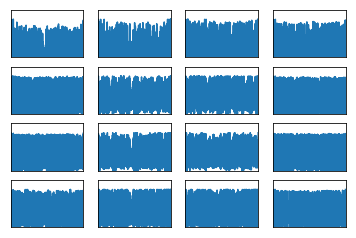

In [315]:
#visu
plt.figure()
for i in range(nbBlocks**2):    
    plt.subplot(4,4,i+1)
    plt.xticks([]), plt.yticks([])
    plt.axis([0, NbImages, 0, 5])
    plt.plot(lChiDistBloc[i])

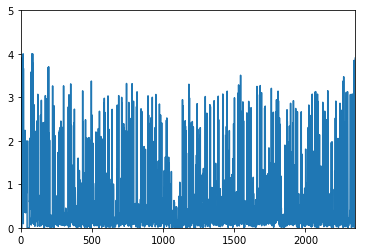

In [316]:
#visu
plt.figure()
plt.axis([0, NbImages,0, 5])
plt.plot(lChiDistBloc[0])
plt.show()

In [322]:
#zero false negatives
seuil1=1.5
seuil2=0.65

#best with normalisation but regumlar chi
#seuil1=0.59
#seuil2=0.70

#the best without normalisation (91,89 and 91.56)
#seuil1=50
#seuil2=0.65
myResult=[]

for im in range(NbImages): 
    blockcounteur=0
    for iblock in range(nbBlocks**2):
        if lChiDistBloc[iblock][im]>seuil1:
            blockcounteur+=1
    if float(blockcounteur)/float(nbBlocks**2)>=seuil2:
        myResult.append(im)
        
precision, recall = myEvaluation(RepCode,myResult)
print(precision)
print(recall)
myWriteCSV(RepCode+'myResult.csv',myResult)  #ne pas changer le nom

95.33582089552239
95.33582089552239
